In [1]:
import torch
import torchvision
import torch.nn as nn
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

In [36]:
batch_size = 128

training_data = torchvision.datasets.FashionMNIST(
    root='./data', 
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = torchvision.datasets.FashionMNIST(
    root='./data', 
    train=False,
    download=True,
    transform=ToTensor()
)

training_loader = torch.utils.data.DataLoader(
    training_data, 
    batch_size=batch_size, 
    shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    test_data, 
    batch_size=batch_size, 
    shuffle=False
)

In [43]:
class FashionMNISTCNN(nn.Module):
    def __init__(self):
        super(FashionMNISTCNN, self).__init__()

        self.conv_1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.pool_1 = nn.MaxPool2d(kernel_size=2)
        
        self.conv_2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.pool_2 = nn.MaxPool2d(kernel_size=2)
        
        self.conv_3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool_3 = nn.MaxPool2d(kernel_size=2) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.25)
        
        self.out = nn.Linear(64 * 3 * 3, 10)

    def forward(self, inputs):
        x = self.conv_1(inputs)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.pool_1(x)
        
        x = self.conv_2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.pool_2(x)

        x = self.conv_3(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.pool_3(x)

        x = x.view(x.size(0), -1)
        x = self.out(x)
        
        return x

In [44]:
model = FashionMNISTCNN()
print(model)

FashionMNISTCNN(
  (conv_1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool_3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (dropout): Dropout(p=0.25, inplace=False)
  (out): Linear(in_features=576, out_features=10, bias=True)
)


In [45]:
def train_model(model, criterion, optimizer, epochs=5, device='cpu'):
    model = model.to(device)

    for epoch in range(epochs):
        model = model.train()
        for batch_idx, (data, target) in enumerate(training_loader):
            data, target = data.to(device), target.to(device)
            
            output = model(data)
            loss = criterion(output, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        print(f"epoch: {epoch}    loss: {loss}")

In [46]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_model(model, criterion, optimizer, epochs=15, device='cuda')

epoch: 0    loss: 0.5157541632652283
epoch: 1    loss: 0.46741631627082825
epoch: 2    loss: 0.25502899289131165
epoch: 3    loss: 0.347401887178421
epoch: 4    loss: 0.41973158717155457
epoch: 5    loss: 0.3087458908557892
epoch: 6    loss: 0.31789061427116394
epoch: 7    loss: 0.29979604482650757
epoch: 8    loss: 0.31730037927627563
epoch: 9    loss: 0.25253745913505554
epoch: 10    loss: 0.25017592310905457
epoch: 11    loss: 0.19226568937301636
epoch: 12    loss: 0.22558502852916718
epoch: 13    loss: 0.17431765794754028
epoch: 14    loss: 0.382783979177475


In [49]:
def test_model(model, device='cpu'):
    model = model.to(device)
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)

            total += target.size(0)
            correct += (predicted == target).sum().item()
            
    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')

In [50]:
test_model(model, 'cuda')

Test Accuracy: 90.92%


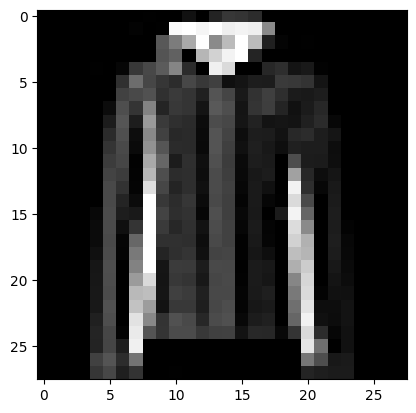

In [51]:
img, label = test_data[6]
plt.imshow(img.squeeze(), cmap="gray")

In [52]:
categories = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"
}

def inference(model, entry_idx, device='cpu'):
    model.to(device)
    model.eval()

    with torch.no_grad():
        data, target = test_data[entry_idx]
        data = data.unsqueeze(0).to(device)

        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)

        pred_n = predicted[0].item()
        
        print(f'Predicted category: {pred_n}')
        print(f'Predicted: {categories.get(pred_n)}')

In [53]:
inference(model, 6, 'cuda')

Predicted category: 4
Predicted: Coat
